Original quality distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

3-class distribution:
quality
0    744
1    638
2    217
Name: count, dtype: int64

Train: (1279, 11) | Test: (320, 11)

Running 5-fold cross-validation for tuning...

k= 1 | uniform: 0.6599 | distance: 0.6599
k= 2 | uniform: 0.6192 | distance: 0.6599
k= 3 | uniform: 0.6137 | distance: 0.6810
k= 4 | uniform: 0.6122 | distance: 0.6802
k= 5 | uniform: 0.6091 | distance: 0.6880
k= 6 | uniform: 0.6052 | distance: 0.6872
k= 7 | uniform: 0.5981 | distance: 0.6818
k= 8 | uniform: 0.6036 | distance: 0.6880
k= 9 | uniform: 0.6052 | distance: 0.6794
k=10 | uniform: 0.6059 | distance: 0.6896
k=11 | uniform: 0.6059 | distance: 0.6865
k=12 | uniform: 0.6083 | distance: 0.6958
k=13 | uniform: 0.6184 | distance: 0.6919
k=14 | uniform: 0.6247 | distance: 0.6958
k=15 | uniform: 0.6122 | distance: 0.6997
k=16 | uniform: 0.6255 | distance: 0.6982
k=17 | uniform: 0.6184 | distance: 0.696

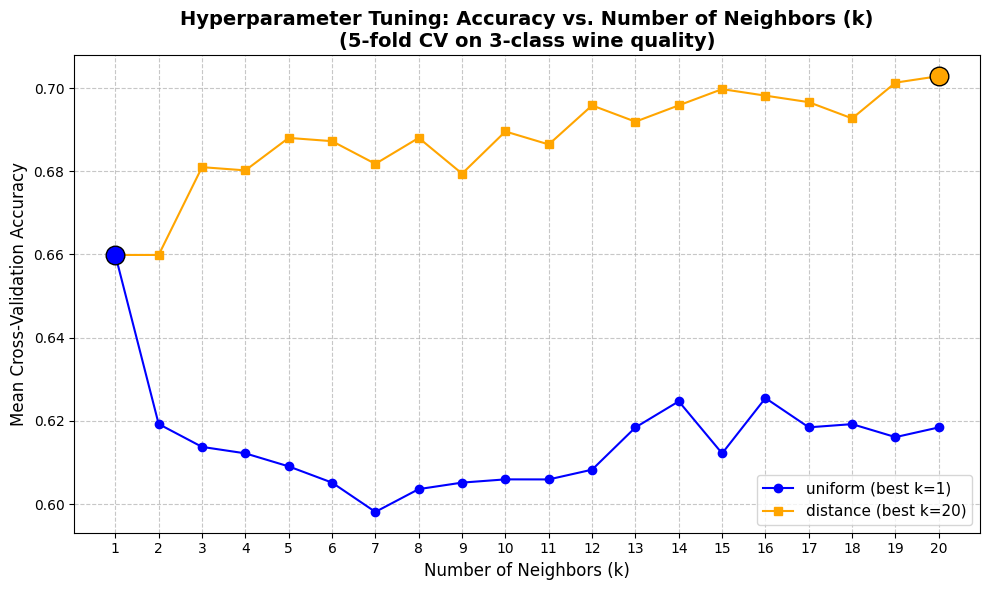


Using final model: k=20, weights='distance'

TEST ACCURACY (3-class): 0.7000  (70.0%)

Classification Report:
              precision    recall  f1-score   support

    Bad (≤5)       0.76      0.78      0.77       149
 Average (6)       0.63      0.62      0.62       128
   Good (≥7)       0.69      0.67      0.68        43

    accuracy                           0.70       320
   macro avg       0.69      0.69      0.69       320
weighted avg       0.70      0.70      0.70       320



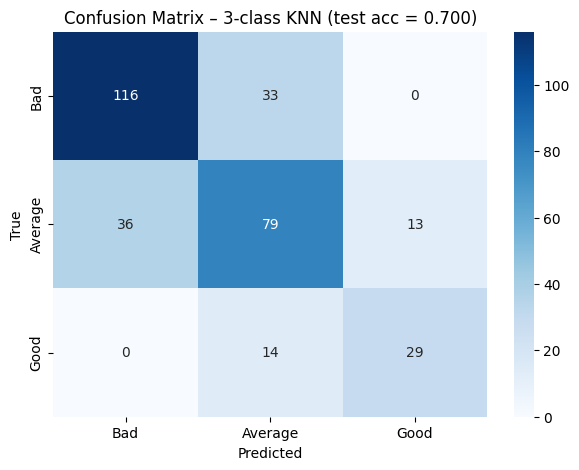

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv('winequality-red.csv')

print("Original quality distribution:")
print(df['quality'].value_counts().sort_index())

def quality_to_class(q):
    if q <= 5:
        return 0
    elif q == 6:
        return 1
    else:
        return 2

y_3class = df['quality'].apply(quality_to_class)
print("\n3-class distribution:")
print(y_3class.value_counts())

X = df.drop('quality', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_3class,
    test_size=0.20,
    random_state=42,
    stratify=y_3class
)

print(f"\nTrain: {X_train.shape} | Test: {X_test.shape}")

k_values = range(1, 21)

uniform_scores  = []
distance_scores = []

print("\nRunning 5-fold cross-validation for tuning...\n")

for k in k_values:
    knn_uni = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    cv_uni = cross_val_score(knn_uni, X_train, y_train, cv=5, scoring='accuracy')
    uniform_scores.append(cv_uni.mean())

    knn_dist = KNeighborsClassifier(n_neighbors=k, weights='distance')
    cv_dist = cross_val_score(knn_dist, X_train, y_train, cv=5, scoring='accuracy')
    distance_scores.append(cv_dist.mean())

    print(f"k={k:2d} | uniform: {cv_uni.mean():.4f} | distance: {cv_dist.mean():.4f}")

best_k_uni   = k_values[np.argmax(uniform_scores)]
best_uni_acc = max(uniform_scores)

best_k_dist   = k_values[np.argmax(distance_scores)]
best_dist_acc = max(distance_scores)

print(f"\nBest uniform  → k = {best_k_uni:<2d}  CV acc = {best_uni_acc:.4f}")
print(f"Best distance → k = {best_k_dist:<2d}  CV acc = {best_dist_acc:.4f}")

plt.figure(figsize=(10, 6))

plt.plot(k_values, uniform_scores, marker='o', color='blue', linestyle='-',
         label=f'uniform (best k={best_k_uni})')
plt.plot(k_values, distance_scores, marker='s', color='orange', linestyle='-',
         label=f'distance (best k={best_k_dist})')

plt.title('Hyperparameter Tuning: Accuracy vs. Number of Neighbors (k)\n(5-fold CV on 3-class wine quality)',
          fontsize=14, fontweight='bold')
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Mean Cross-Validation Accuracy', fontsize=12)

plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(k_values)

ymin = min(min(uniform_scores), min(distance_scores)) - 0.005
ymax = max(max(uniform_scores), max(distance_scores)) + 0.005
plt.ylim(ymin, ymax)

plt.scatter(best_k_uni, best_uni_acc, s=180, color='blue', edgecolor='black', zorder=10)
plt.scatter(best_k_dist, best_dist_acc, s=180, color='orange', edgecolor='black', zorder=10)

plt.tight_layout()
plt.show()

best_k = best_k_dist if best_dist_acc >= best_uni_acc else best_k_uni
best_weights = 'distance' if best_k == best_k_dist else 'uniform'

print(f"\nUsing final model: k={best_k}, weights='{best_weights}'")

knn_final = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights)
knn_final.fit(X_train, y_train)

y_pred = knn_final.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\nTEST ACCURACY (3-class): {acc:.4f}  ({acc*100:.1f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=['Bad (≤5)', 'Average (6)', 'Good (≥7)']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad', 'Average', 'Good'],
            yticklabels=['Bad', 'Average', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix – 3-class KNN (test acc = {acc:.3f})')
plt.show()